<a href="https://colab.research.google.com/github/20KMJ/ESAA7/blob/main/0529_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%95%A9%EC%84%B1%EA%B3%B11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 04 | 합성곱 신경망(CNN)

# 01. 합성곱 신경망 

**합성곱 신경망(CNN : Convolutional Neural Network)**: 데이터가 가진 특징들의 패턴을 학습하는 알고리즘 -> 이미지 분류, 객체 탐지, 스타일 전이 등

- 이미지 분류: 모델은 이미지를 인식할 수 있는 능력을 갖춤
- 객체 탐지: 이미지에서 특정한 객체를 인식하고 이미지의 어디에 있는지 위치까지 파악하는 기술(경계 박스. bounding box)
- 스타일 전이: 콘텐츠 이미지와 스타일 참조 이미지를 이용해 콘텐츠의 기본 형태를 유지하고 스타일을 입혀서 새로운 이미지를 생성하는 기술

## 1-1. 이미지 표현

이미지(또는 영상) -> 숫자로 표현(0~255)
1. 흑백  
0(검은색) ~ 255(흰색)  
2. 컬러(3채널(RGB))  
R+G+B  
범위: 각각 0~255

## 1-2. 합성곱(Convolution)

**합성곱 연산**: 커널(n * m크기의 행렬)을 사용해서 이미지를 처음부터 끝까지 겹치며 훑으면서 n * m 크기의 겹쳐지는 부분의 각 이미지와 커널의 원소의 값을 곱해서 모두 더한 값을 출력하는 것  
**특성맵(featurre map)**: 합성곱 연산을 통해서 추출된 이미지 -> 딥러닝 모델 학습에 사용 시 좋은 성능을 보임

합성곱 신경망은 이미지 특성 추출에 효율적인데, 이는 '커널의 공유 가중치(shared weights)' 때문이다. 오차 역전파 시 커널의 그래디언트(gradient)를 계산할 때 완전 연결층을 사용할 때보다 연산량이 훨씬 적다는 장점이 있다.

## 1-3. 채널(channel)

**채널**: 입력 이미지를 구성하는 2차원 배열의 개수

흑백 이미지: 단일 채널(채널 1개)

컬러 이미지: R,G,B (채널 3개)

## 1-4. 스트라이드(stride)

커널은 좌측 상단으로부터 입력 이미지를 기준으로 우측으로 이동하면서 합성곱 연산을 계속 수행하고 특성맵에 결과를 채워나간다. 이때 이동하는 간격을 **스트라이드(stride)**로 정의한다.

텐서플로 케라스의 Convd2D 레이어의 `strides` 매개변수에 스트라이드를 지정

## 1-5. 패딩(padding)

추출된 특성맵의 크기가 입력 이미지 대비 줄어들지 않도록 패딩(padding)을 설정할 수 있다.

**zero-padding**: 입력 이미지의 가장자리에 0으로 채워진 패딩 값으로 채운 후 추출. 텐서플로 케라스의 Covn2D 레이어에서 `padding='same'`으로 설정하면 zero-padding을 적용함.

패딩을 적용한 후 합성곱 연산을 수행하게 되면 특성맵의 크기가 줄어들지 않는다.

## 1-6. 특성맵(feature map) 사이즈

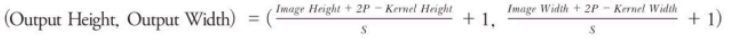

- Image Heigth, Image Width: 입력 크기(input size)
- Kernel Height, Kernel Width: 필터 크기(kernel size)
- S : 스트라이드(strides)
- P : 패딩(padding)
- Output Height, Output Width: 출력 크기(output size)

## 1-7. 풀링(pooling)

**풀링(pooling)** 레이어는 추출된 특성맵에 대해 다운 샘플링하여 이미지의 크기를 축소하는 레이어

이점: 이미지 축소를 통해 연산량을 감소함 & 과대적합(overfiting) 방지

최대 풀링(max pooling) vs 평균 풀링(average pooling)

# 02. 간단한 모델 생성

## 2-1. 데이터 로드 및 전처리

In [ ]:
# tensorflow 모듈 import 
import tensorflow as tf

In [ ]:
# MNIST 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx], cmap="gray")
    plt.axis("off")
    plt.show()

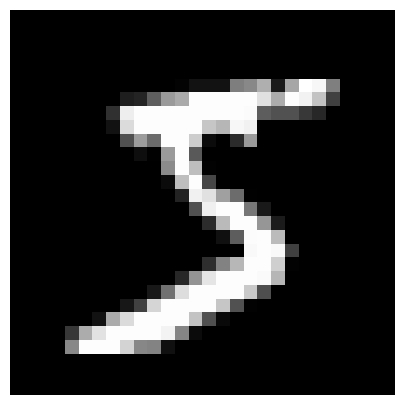

In [ ]:
plot_image(x_train, 0)

In [ ]:
print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0 255
0 255


In [ ]:
# 정규화(Normalization)
x_train = x_train/255.0
x_valid = x_valid/255.0

print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0.0 1.0
0.0 1.0


> CNN 모델에 주입하기 위해서 색상을 나타내는 채널 추가

In [ ]:
# 채널 추가
print("변환 전 텐서 형태 :", x_train.shape, x_valid.shape)

x_train_in = x_train[..., tf.newaxis]
x_valid_in = x_valid[..., tf.newaxis]

print("변환 후 텐서 형태 :", x_train_in.shape, x_valid_in.shape)

변환 전 텐서 형태 : (60000, 28, 28) (10000, 28, 28)
변환 후 텐서 형태 : (60000, 28, 28, 1) (10000, 28, 28, 1)


## 2-2. Sequantial API로 모델 생성 및 학습

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성
model = tf.keras.Sequential([
    # 합성곱 레이어 : Convolution 적용(32 filters)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), name='conv'),

    # 풀링 레이어 : Max Pooling 적용
    tf.keras.layers.MaxPooling2D((2, 2), name='pool'),

    # Classifier 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
])

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 모델 훈련
history = model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.2167 - accuracy: 0.9391 - val_loss: 0.0905 - val_accuracy: 0.9728
Epoch 2/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0812 - accuracy: 0.9762 - val_loss: 0.0666 - val_accuracy: 0.9787
Epoch 3/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0625 - accuracy: 0.9812 - val_loss: 0.0595 - val_accuracy: 0.9821
Epoch 4/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0511 - accuracy: 0.9850 - val_loss: 0.0592 - val_accuracy: 0.9803
Epoch 5/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0437 - accuracy: 0.9870 - val_loss: 0.0616 - val_accuracy: 0.9807
Epoch 6/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0377 - accuracy: 0.9884 - val_loss: 0.0558 - val_accuracy: 0.9824
Epoch 7/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0320 - accuracy: 0.9901 - val_loss: 0.0505 -

In [ ]:
model.evaluate(x_valid_in, y_valid)

313/313 [==============================] - 3s 9ms/step - loss: 0.0592 - accuracy: 0.9822


[0.05922076478600502, 0.982200026512146]

In [ ]:
# 훈련 과정 시각화 함수
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

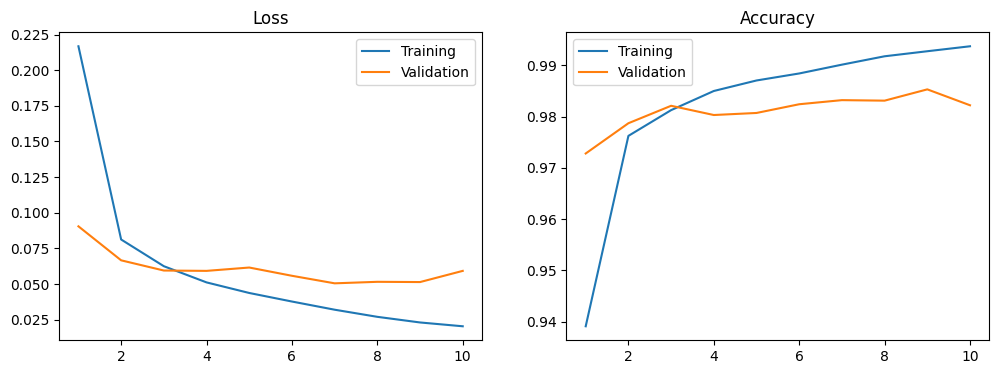

In [ ]:
plot_loss_acc(history, 10)

## 2-3. 모델 구조 파악

(28, 28, 1) 형태의 입력 텐서가 **Conv2D**를 거치면서 (26, 26, 32) 형태로 변환됨.

(3, 3) 크기의 합성곱 필터를 사용하기 때문에 이미지 가로, 세로 크기가 2씩 줄어듬 (패딩은 적용 안됨)

서로 다른 32개의 필터를 적용했으므로 (26, 26) 크기의 특성맵이 32개 생성됨.

즉, (28, 28, 1) 이미지에 서로 다른 32개 커널을 적용해서 32가지 종류의 피처(특징)를 추출함.

(2, 2) 크기의 풀링 레이어를 적용했기 때문에 이미지 크기가 1/2로 줄어듬. 따라서 풀링 레이러를 거치면 (13, 13, 32) 텐서로 변환되고, Flatten 층에서 3차원 텐서를 1차원 텐서로 펼치면 5,408개(13 * 13 * 32)원소를 갖는 1차원 벡터가 됨.

이 벡터를 출력 노드 10개인 Dense 레이어로 보내면 최종 분류 값을 예측해 출력함. 즉, 이미지를 입력받아 특징을 추출하고 이미지가 나타내는 숫자를 예측할 수 있음

In [ ]:
# 모델 구조 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 26, 26, 32)        320       
                                                                 
 pool (MaxPooling2D)         (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 입력 텐서 형태 
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [ ]:
# 출력 텐서 형태 
model.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>

In [ ]:
# 레이어 
model.layers

In [ ]:
# 첫번째 레이어 선택
model.layers[0]

In [ ]:
# 첫번째 레이어 입력
model.layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [ ]:
# 첫번째 레이어 출력
model.layers[0].output

<KerasTensor: shape=(None, 26, 26, 32) dtype=float32 (created by layer 'conv')>

In [ ]:
# 첫번째 레이어 가중치
model.layers[0].weights

[<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[ 2.73620158e-01, -3.84872049e-01, -7.81772435e-01,
           -3.32229555e-01,  2.37768456e-01,  3.46114516e-01,
            3.37804407e-01,  2.68880218e-01, -3.23477417e-01,
           -4.24073815e-01, -3.77502233e-01, -4.03924704e-01,
            1.21578783e-01,  1.77560851e-01,  3.10101174e-02,
           -4.42089826e-01, -5.58559239e-01,  1.48055270e-01,
           -8.76087666e-01,  1.05206579e-01, -5.27115524e-01,
           -8.62877786e-01, -9.49516669e-02, -5.95800690e-02,
            1.21340662e-01,  3.00481111e-01, -8.45028996e-01,
            3.63269001e-01,  2.25652993e-01,  2.61917055e-01,
            2.24823460e-01, -5.54331124e-01]],
 
         [[ 2.17228875e-01, -1.77023768e-01, -9.26641047e-01,
            1.49069771e-01, -4.81887430e-01,  3.11101019e-01,
            4.24599558e-01,  2.26692230e-01, -3.87164831e-01,
            1.51819885e-01, -7.50376880e-01,  3.40299793e-02,
           

In [ ]:
# 첫번째 레이어 커널 가중치
model.layers[0].kernel

<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[ 2.73620158e-01, -3.84872049e-01, -7.81772435e-01,
          -3.32229555e-01,  2.37768456e-01,  3.46114516e-01,
           3.37804407e-01,  2.68880218e-01, -3.23477417e-01,
          -4.24073815e-01, -3.77502233e-01, -4.03924704e-01,
           1.21578783e-01,  1.77560851e-01,  3.10101174e-02,
          -4.42089826e-01, -5.58559239e-01,  1.48055270e-01,
          -8.76087666e-01,  1.05206579e-01, -5.27115524e-01,
          -8.62877786e-01, -9.49516669e-02, -5.95800690e-02,
           1.21340662e-01,  3.00481111e-01, -8.45028996e-01,
           3.63269001e-01,  2.25652993e-01,  2.61917055e-01,
           2.24823460e-01, -5.54331124e-01]],

        [[ 2.17228875e-01, -1.77023768e-01, -9.26641047e-01,
           1.49069771e-01, -4.81887430e-01,  3.11101019e-01,
           4.24599558e-01,  2.26692230e-01, -3.87164831e-01,
           1.51819885e-01, -7.50376880e-01,  3.40299793e-02,
          -1.81055322e-01,  

In [ ]:
# 첫번째 레이어 bias 가중치
model.layers[0].bias

<tf.Variable 'conv/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.21458814, -0.21146007, -0.03560094, -0.25922313, -0.06601786,
       -0.25593692, -0.01265334, -0.21613896, -0.25647536, -0.27470282,
       -0.00506595, -0.0582022 , -0.18422765, -0.27538672, -0.03956823,
       -0.10482546, -0.19777709, -0.25377488,  0.11925316,  0.03167355,
       -0.21686223, -0.02588452, -0.2778352 , -0.21321692, -0.01239494,
       -0.43797657,  0.13838923, -0.15009694, -0.18581715, -0.3043131 ,
       -0.20962256, -0.03322155], dtype=float32)>

In [ ]:
# 레이어 이름 사용하여 레이어 선택
model.get_layer('conv')

In [ ]:
# 샘플 이미지의 레이어별 출력을 리스트에 추가 (첫번째, 두번째 레이어)
activator = tf.keras.Model(inputs=model.input, outputs=[layer.output for layer in model.layers[:2]] ) 
activations = activator.predict(x_train_in[0][tf.newaxis, ...]) 

len(activations)

1/1 [==============================] - 0s 106ms/step


2

In [ ]:
# 첫 번째 레이어(conv) 출력층 
conv_activation = activations[0]
conv_activation.shape

(1, 26, 26, 32)

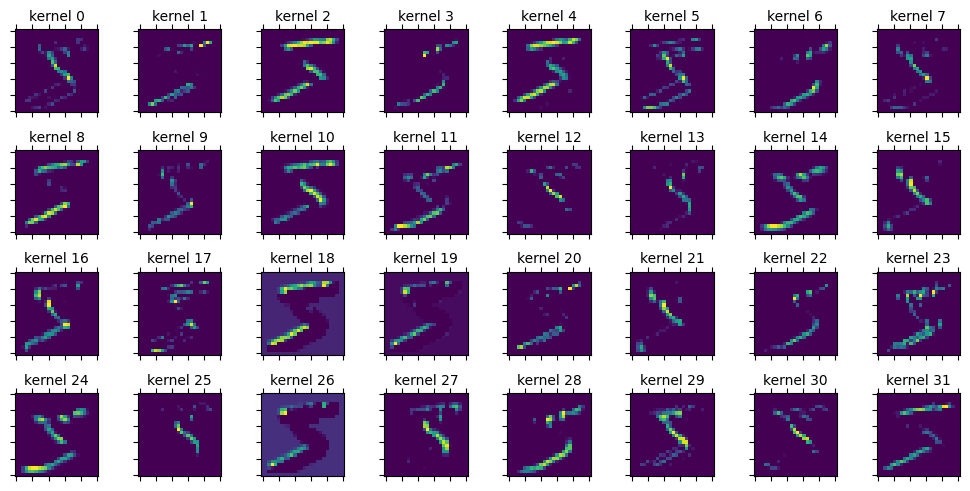

In [ ]:
# Convolution 시각화
fig, axes = plt.subplots(4, 8)
fig.set_size_inches(10, 5)

for i in range(32):
    axes[i//8, i%8].matshow(conv_activation[0, :, :, i], cmap='viridis')
    axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
    plt.setp( axes[i//8, i%8].get_xticklabels(), visible=False)
    plt.setp( axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

In [ ]:
# 두 번째 레이어(pool) 출력층 
pooling_activation = activations[1]
print(pooling_activation.shape)  

(1, 13, 13, 32)


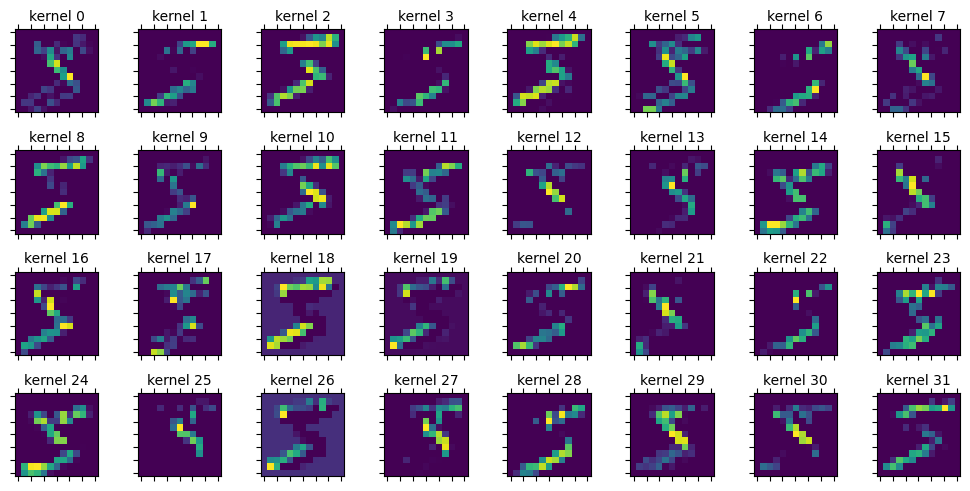

In [ ]:
#시각화
fig, axes = plt.subplots(4, 8)
fig.set_size_inches(10, 5)

for i in range(32):
    axes[i//8, i%8].matshow(pooling_activation[0, :, :, i], cmap='viridis')
    axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
    plt.setp( axes[i//8, i%8].get_xticklabels(), visible=False)
    plt.setp( axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

# 03. 복잡한 모델 생성

텐서플로 케라스의 Functional API를 사용하면, Sequential API로 구현할 수 없는 복잡한 구조의 모델을 정의할 수 있음. 중간에 있는 레이어들을 건너뛰고 뒤쪽에 있는 레이어로 출력 텐서를 전달하는 방식으로 직접 연결하는 방법도 가능함

## 3-1. 데이터셋 준비

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
# MNIST 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
# 새로운 출력값 배열을 생성 (홀수: 1, 짝수: 0)
y_train_odd = []
for y in y_train:
    if y % 2==0:
        y_train_odd.append(0)
    else:
        y_train_odd.append(1)

y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [ ]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


In [ ]:
# Validation 데이터셋 처리
y_valid_odd = []
for y in y_valid:
    if y % 2==0:
        y_valid_odd.append(0)
    else:
        y_valid_odd.append(1)

y_valid_odd = np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

> 새로운 축 추가

(60000, 28, 28) 배열이 (60000, 28, 28, 1) 배열이 됨

In [ ]:
# 정규화(Normalization)
x_train = x_train/255.0
x_valid = x_valid/255.0

# 채널 추가
x_train_in = tf.expand_dims(x_train, -1)
x_valid_in = tf.expand_dims(x_valid, -1)

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## 3-2. Functional API로 다중 입력. 다중 출력 레이어 생성

In [ ]:
# Functional API를 사용하여 모델 생성
inputs = tf.keras.layers.Input(shape=(28, 28, 1))

conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
flat = tf.keras.layers.Flatten()(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)

concat = tf.keras.layers.Concatenate()([flat, flat_inputs])

outputs = tf.keras.layers.Dense(10, activation='softmax')(concat)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 flatten_1 (Flatten)            (None, 5408)         0           ['max_pooling2d[0][0]']          
                                                                                            

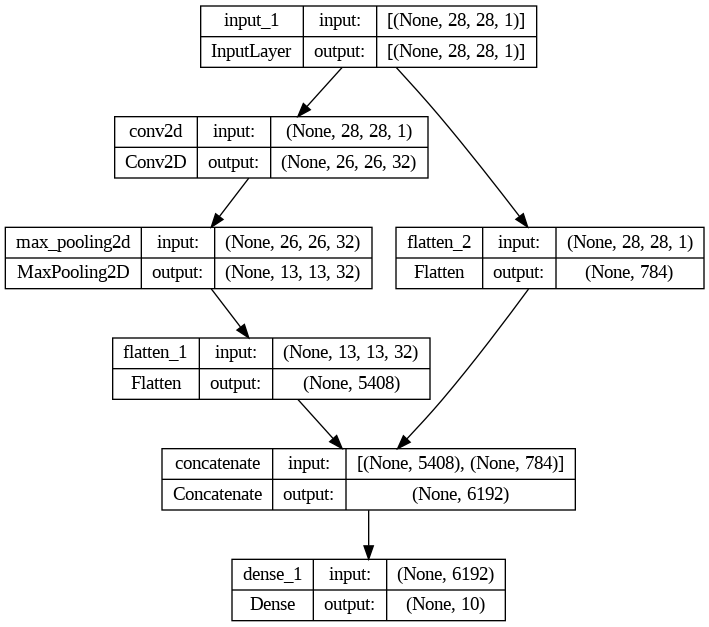

In [ ]:
# 모델 구조 출력 및 이미지 파일로 저장
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 모델 훈련
history = model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 35s 18ms/step - loss: 0.2061 - accuracy: 0.9415 - val_loss: 0.0832 - val_accuracy: 0.9748
Epoch 2/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0809 - accuracy: 0.9760 - val_loss: 0.0743 - val_accuracy: 0.9758
Epoch 3/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0616 - accuracy: 0.9817 - val_loss: 0.0643 - val_accuracy: 0.9780
Epoch 4/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0498 - accuracy: 0.9847 - val_loss: 0.0637 - val_accuracy: 0.9797
Epoch 5/10
1875/1875 [==============================] - 38s 21ms/step - loss: 0.0424 - accuracy: 0.9872 - val_loss: 0.0611 - val_accuracy: 0.9789
Epoch 6/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0344 - accuracy: 0.9897 - val_loss: 0.0528 - val_accuracy: 0.9838
Epoch 7/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0300 - accuracy: 0.9908 - val_loss: 0.0567 -

## 3-3. 다중 출력 분류 모델

> 두 가지 서로 다른 분류 문제를 예측하는 다중 출력 모델을 만들어보자

In [ ]:
# Functional API를 사용하여 모델 생성
inputs = tf.keras.layers.Input(shape=(28, 28, 1), name='inputs')

conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_layer')(inputs)
pool = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_layer')(conv)
flat = tf.keras.layers.Flatten(name='flatten_layer')(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])

digit_outputs = tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat) # 0~9까지의 숫자
odd_outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs) # 홀짝

In [ ]:
model = tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_layer (Conv2D)          (None, 26, 26, 32)   320         ['inputs[0][0]']                 
                                                                                                  
 maxpool_layer (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d_layer[0][0]']           
                                                                                                  
 flatten_layer (Flatten)        (None, 5408)         0           ['maxpool_layer[0][0]']          
                                                                                            

In [ ]:
# 모델의 입력과 출력을 나타내는 텐서
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]


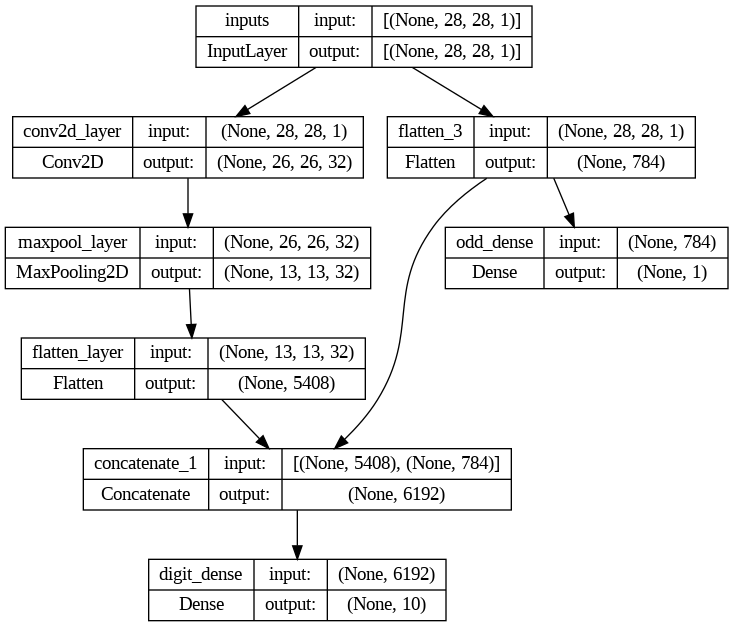

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', 
              loss={'digit_dense': 'sparse_categorical_crossentropy', 'odd_dense': 'binary_crossentropy'}, 
              loss_weights={'digit_dense': 1, 'odd_dense': 0.5}, # loss = 1.0 *sparse_categorical_crossentropy + 0.5*binary_crossentropy
              metrics=['accuracy'])

In [ ]:
# 모델 훈련
history = model.fit({'inputs': x_train_in},
                    {'digit_dense': y_train, 'odd_dense': y_train_odd}, 
                    validation_data=({'inputs': x_valid_in},  {'digit_dense': y_valid, 'odd_dense': y_valid_odd}), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.3702 - digit_dense_loss: 0.2068 - odd_dense_loss: 0.3267 - digit_dense_accuracy: 0.9406 - odd_dense_accuracy: 0.8627 - val_loss: 0.2380 - val_digit_dense_loss: 0.1004 - val_odd_dense_loss: 0.2751 - val_digit_dense_accuracy: 0.9706 - val_odd_dense_accuracy: 0.8873
Epoch 2/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2131 - digit_dense_loss: 0.0772 - odd_dense_loss: 0.2717 - digit_dense_accuracy: 0.9777 - odd_dense_accuracy: 0.8914 - val_loss: 0.2020 - val_digit_dense_loss: 0.0700 - val_odd_dense_loss: 0.2640 - val_digit_dense_accuracy: 0.9775 - val_odd_dense_accuracy: 0.8948
Epoch 3/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.1896 - digit_dense_loss: 0.0582 - odd_dense_loss: 0.2629 - digit_dense_accuracy: 0.9824 - odd_dense_accuracy: 0.8951 - val_loss: 0.1951 - val_digit_dense_loss: 0.0654 - val_odd_dense_loss: 0.2593 - val_digit_dense_accuracy: 0.9789 -

In [ ]:
# 모델 성능
model.evaluate({'inputs': x_valid_in}, {'digit_dense': y_valid, 'odd_dense': y_valid_odd})

313/313 [==============================] - 3s 8ms/step - loss: 0.1862 - digit_dense_loss: 0.0585 - odd_dense_loss: 0.2554 - digit_dense_accuracy: 0.9840 - odd_dense_accuracy: 0.9000


[0.18616968393325806,
 0.05847082659602165,
 0.25539788603782654,
 0.984000027179718,
 0.8999999761581421]

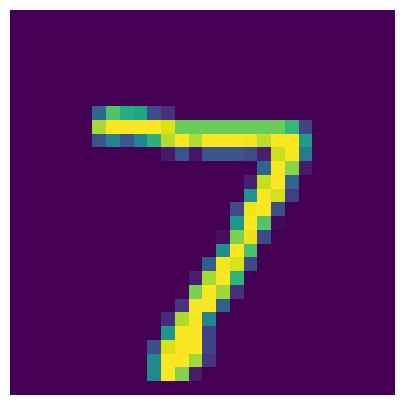

In [ ]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx])
    plt.axis("off")
    plt.show()

plot_image(x_valid, 0)

In [ ]:
digit_preds, odd_preds = model.predict(x_valid_in)
print(digit_preds[0])
print(odd_preds[0])

313/313 [==============================] - 3s 8ms/step
[1.63870209e-12 6.28043659e-11 2.65935229e-09 1.05511276e-06
 3.60455693e-11 6.02300328e-12 5.59891286e-20 9.99998868e-01
 1.41835175e-08 1.32078144e-08]
[0.99960303]


In [ ]:
digit_labels = np.argmax(digit_preds, axis=-1)
digit_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [ ]:
odd_labels = (odd_preds > 0.5).astype(np.int).reshape(1, -1)[0]
odd_labels[0:10]

<ipython-input-52-cb61980817f6>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  odd_labels = (odd_preds > 0.5).astype(np.int).reshape(1, -1)[0]


array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1])

## 3-4. 전이 학습(Transfer Learning)

**Transfer Learning**: 기존에 학습된 모델을 활용해 새로운 모델을 만들어 내는 개념

In [ ]:
# 앞의 모델에서 flatten_layer 출력을 추출
base_model_output = model.get_layer('flatten_layer').output

# 앞의 출력을 출력으로 하는 모델 정의
base_model = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


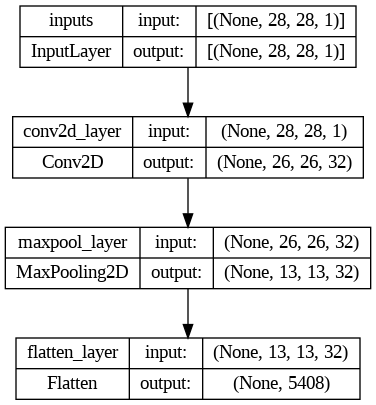

In [ ]:
plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

In [ ]:
# Sequential API 적용
digit_model = tf.keras.Sequential([base_model,
                                   tf.keras.layers.Dense(10, activation='softmax'),])

digit_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 5408)              320       
                                                                 
 dense_2 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


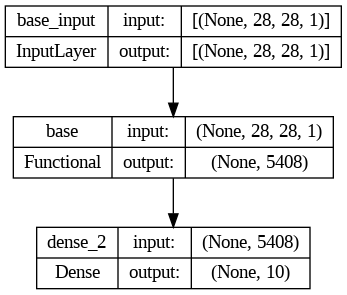

In [ ]:
plot_model(digit_model, show_shapes=True, show_layer_names=True, to_file='digit_model.png')  

In [ ]:
# 모델 컴파일
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.1299 - accuracy: 0.9634 - val_loss: 0.0733 - val_accuracy: 0.9767
Epoch 2/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0569 - accuracy: 0.9830 - val_loss: 0.0574 - val_accuracy: 0.9820
Epoch 3/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0443 - accuracy: 0.9864 - val_loss: 0.0554 - val_accuracy: 0.9820
Epoch 4/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0357 - accuracy: 0.9888 - val_loss: 0.0515 - val_accuracy: 0.9840
Epoch 5/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0283 - accuracy: 0.9914 - val_loss: 0.0505 - val_accuracy: 0.9845
Epoch 6/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0234 - accuracy: 0.9931 - val_loss: 0.0485 - val_accuracy: 0.9844
Epoch 7/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0195 - accuracy: 0.9937 - val_loss: 0.0537 -

In [ ]:
# 베이스 모델의 가중치를 고정 (Freeze Model)
base_model_frozen = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen')
base_model_frozen.trainable = False
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


In [ ]:
# Functional API 적용
dense_output = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = tf.keras.models.Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

In [ ]:
# 모델 컴파일
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1146 - accuracy: 0.9691 - val_loss: 0.0604 - val_accuracy: 0.9813
Epoch 2/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0485 - accuracy: 0.9860 - val_loss: 0.0509 - val_accuracy: 0.9845
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0358 - accuracy: 0.9894 - val_loss: 0.0524 - val_accuracy: 0.9840
Epoch 4/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0275 - accuracy: 0.9916 - val_loss: 0.0472 - val_accuracy: 0.9849
Epoch 5/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0214 - accuracy: 0.9938 - val_loss: 0.0494 - val_accuracy: 0.9856
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0183 - accuracy: 0.9944 - val_loss: 0.0530 - val_accuracy: 0.9833
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0145 - accuracy: 0.9959 - val_loss: 0.0534 - val_ac

In [ ]:
# 베이스 모델의 Conv2D 레이어의 가중치만 고정(Freeze Layer)
base_model_frozen2 = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable = False
base_model_frozen2.summary()

Model: "base_frozen2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


In [ ]:
# Functional API 적용
dense_output2 = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen2.output)
digit_model_frozen2 = tf.keras.models.Model(inputs=base_model_frozen2.input, outputs=dense_output2)
digit_model_frozen2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

In [ ]:
# 모델 컴파일
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen2.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1173 - accuracy: 0.9690 - val_loss: 0.0644 - val_accuracy: 0.9798
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0489 - accuracy: 0.9859 - val_loss: 0.0479 - val_accuracy: 0.9843
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0367 - accuracy: 0.9889 - val_loss: 0.0546 - val_accuracy: 0.9827
Epoch 4/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0278 - accuracy: 0.9917 - val_loss: 0.0559 - val_accuracy: 0.9831
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0231 - accuracy: 0.9930 - val_loss: 0.0515 - val_accuracy: 0.9843
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0178 - accuracy: 0.9949 - val_loss: 0.0525 - val_accuracy: 0.9845
Epoch 7/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0151 - accuracy: 0.9956 - val_loss: 0.0559 - val_a